In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path.cwd().parent.resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

# Verify that the path has been added correctly
print(sys.path[0])

from diffusers import FluxPipeline
from diffusers.models import AutoencoderTiny
import torch
import os
os.environ['HF_HOME'] = '/dlabscratch1/anmari'
os.environ['TRANSFORMERS_CACHE'] = '/dlabscratch1/anmari'
os.environ['HF_DATASETS_CACHE'] = '/dlabscratch1/anmari'

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from PIL import Image
from importlib import reload

/mnt/dlabscratch1/anmari/dit-editor


In [2]:
import torch
import gc
from accelerate.utils import release_memory

def clear_all_gpu_memory():
    # Run garbage collection
    gc.collect()

    # Get number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Found {num_gpus} GPU(s).")

    # Iterate through each GPU
    for device_id in range(num_gpus):
        with torch.cuda.device(device_id):
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.reset_accumulated_memory_stats()
            release_memory()
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.ipc_collect()
    print("GPU memory cleared across all available devices.")

## FLUX

In [3]:
from diffusers import FluxPipeline

dtype = torch.float16
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", 
                                    device_map="balanced",
                                    torch_dtype=dtype)
pipe.set_progress_bar_config(disable=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 80.00 MiB. GPU 0 has a total capacity of 79.14 GiB of which 59.19 MiB is free. Process 1691239 has 47.01 GiB memory in use. Process 1780882 has 32.06 GiB memory in use. Of the allocated memory 31.33 GiB is allocated by PyTorch, and 255.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import cache_and_edit
reload(cache_and_edit)
from cache_and_edit import *
import cache_and_edit.hooks
reload(cache_and_edit.hooks)

cached_pipe = CachedPipeline(pipe)
# cached_pipe_dest = CachedPipeline(pipe)

In [ ]:
from typing import Optional, Tuple

def resize_bounding_box(
    bb_mask: torch.Tensor,
    target_size: Tuple[int, int] = (64, 64),
) -> torch.Tensor:
    """
    Given a bounding box mask, patches it into a mask with the target size.
    The mask is a 2D tensor of shape (H, W) where each element is either 0 or 1.
    Any patch that contains at least one 1 in the original mask will be set to 1 in the output mask.

    Args:
        bb_mask (torch.Tensor): The bounding box mask as a boolean tensor of shape (H, W).
        target_size (Tuple[int, int]): The size of the target mask as a tuple (H, W).

    Returns:
        torch.Tensor: The resized bounding box mask as a boolean tensor of shape (H, W).
    """
    
    w_mask, h_mask = bb_mask.shape[-2:]
    w_target, h_target = target_size

    # Make sure the sizes are compatible
    if w_mask % w_target != 0 or h_mask % h_target != 0:
        raise ValueError(
            f"Mask size {bb_mask.shape[-2:]} is not compatible with target size {target_size}"
        )
    
    # Compute the size of a patch
    patch_size = (w_mask // w_target, h_mask // h_target)
    print(f"patch_size: {patch_size}")

    # Iterate over the mask, one patch at a time, and save a 0 patch if the patch is empty or a 1 patch if the patch is not empty
    out_mask = torch.zeros((w_target, h_target), dtype=bb_mask.dtype, device=bb_mask.device)
    for i in range(w_target):
        for j in range(h_target):
            patch = bb_mask[
                i * patch_size[0] : (i + 1) * patch_size[0],
                j * patch_size[1] : (j + 1) * patch_size[1],
            ]
            if torch.sum(patch) > 0:
                out_mask[i, j] = 1
            else:
                out_mask[i, j] = 0

    return out_mask


def get_combined_latents(
    bg_latents: torch.Tensor,
    fg_latents: torch.Tensor,
    bb_mask: torch.Tensor,
) -> torch.Tensor:
    """
    Given a background and foreground latents, and a bounding box mask,
    combine the latents into a single tensor by putting the foreground latents
    inside the bounding box mask and the background latents outside of it.

    Args:
        bg_latents (torch.Tensor): The background latents as a tensor of shape (H * W, C).
        fg_latents (torch.Tensor): The foreground latents as a tensor of shape (H * W, C).
        bb_mask (torch.Tensor): The bounding box mask as a boolean tensor of shape (H * W, ).

    Returns:
        torch.Tensor: The combined latents as a tensor of shape (H * W, C).

    """

    if bb_mask.ndim == 2:
        bb_mask = bb_mask.flatten()

    assert bg_latents.shape == fg_latents.shape, "Background and foreground latents must have the same shape"
    assert bg_latents.shape[0] == bb_mask.shape[0], "Background latents and bounding box mask must have the same number of elements"
    assert fg_latents.shape[0] == bb_mask.shape[0], "Foreground latents and bounding box mask must have the same number of elements"

    if bb_mask.dtype == torch.bool:
        bb_mask = bb_mask.float()
    if bb_mask.ndim == 1:
        bb_mask = bb_mask.unsqueeze(1)

    
    # Create a new tensor to hold the combined latents
    combined_latents = bg_latents * (1 - bb_mask) + fg_latents * bb_mask
    return combined_latents

In [ ]:
 # [0, 1, 2, 17, 18, 25, 28, 53, 54, 56].  [28, 53, 54, 56, 25]
vital_layers = [f"transformer.transformer_blocks.{i}" for i in [0, 1, 17, 18]] + \
                [f"transformer.single_transformer_blocks.{i-19}" for i in [25, 28, 53, 54, 56]]
mask_path = "../benchmark_images_generations/Real-Real/0001 a professional photograph of a puppy in the snow, ultra realistic/mask_bg_fg.jpg"
mask = Image.open(mask_path).convert("L")
# convert to tensor
mask = np.array(mask)
mask = torch.from_numpy(mask)
mask = mask / 255.0
mask = resize_bounding_box(mask, target_size=(64, 64)).flatten().unsqueeze(1)
prompts = ["a house in the forest", "a green cow", "a house in the forest"]

patch_size: (8, 8)


In [13]:
images = cached_pipe.run_inject_qkv(
    prompts,
    num_inference_steps=15,
    seed=42,
    guidance_scale=3.5,
    empty_clip_embeddings=False,
    q_mask=mask.to(dtype=bool),
    positions_to_inject = [f"transformer.transformer_blocks.{i}" for i in [0, 1, 2, 17, 18]]  +  [f"transformer.single_transformer_blocks.{i}" for i in range(38)],
    positions_to_inject_foreground = [f"transformer.transformer_blocks.{i}" for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]], # + [f"transformer.single_transformer_blocks.{i}" for i in range(38)], #  + [f"transformer.single_transformer_blocks.{i}" for i in range(2)],
    # latents=torch.stack([background_noise, foreground_noise, torch.Tensor(background_noise)], dim=0),
).images

In [6]:
def display_images(imgs: list):
    fig, axes = plt.subplots(1, len(imgs), figsize=(len(imgs)*5, 5))
    for ax, im in zip(axes, imgs):
        ax.imshow(im)
        ax.axis('off')  # hide axes ticks

    plt.tight_layout()
    plt.show()

display_images(images)

NameError: name 'images' is not defined

In [ ]:
import torch.nn.functional as F


@torch.no_grad
def patch_foreground_activations(input: torch.Tensor, 
                output: torch.Tensor,
                layer: int,
                weight: float = 1.0,
                mask: torch.Tensor = None,
                ):
    
    # 1) find the bounding‐box of the True rectangle    
    ys, xs = mask.reshape(64, 64).nonzero(as_tuple=True)
    y0, y1 = ys.min(), ys.max() 
    x0, x1 = xs.min(), xs.max()
    h_rect = (y1 - y0 + 1)
    w_rect = (x1 - x0 + 1)

    print(h_rect, w_rect)

    foreground_out = output[1].reshape(64, 64, -1)

    # 2) pool x down to (h_rect, w_rect)
    #    - permute into NCHW
    x_nchw = foreground_out.permute(2, 0, 1).unsqueeze(0)     # [1, C, H, W]
    pooled = F.adaptive_avg_pool2d(x_nchw, (h_rect, w_rect))
    pooled = pooled.squeeze(0).permute(1, 2, 0)  # [h_rect, w_rect, C]

    # 3) scatter it back into a zero‐tensor of original shape
    patched_output = torch.zeros_like(foreground_out)                    # [H, W, C]
    patched_output[y0 : y1+1, x0 : x1+1] = pooled

    patched_output = patched_output.reshape(1, 4096, -1)

    output[2:] += patched_output

    return output

@torch.no_grad
def patch_foreground_activations_flat(input: torch.Tensor, 
                output: torch.Tensor,
                layer: int,
                weight: float = 1.0,
                mask: torch.Tensor = None,
                ):

    output[2:][mask] = (output[2:][mask] * 0.8 + output[1:2][mask] * 0.2)

    return output

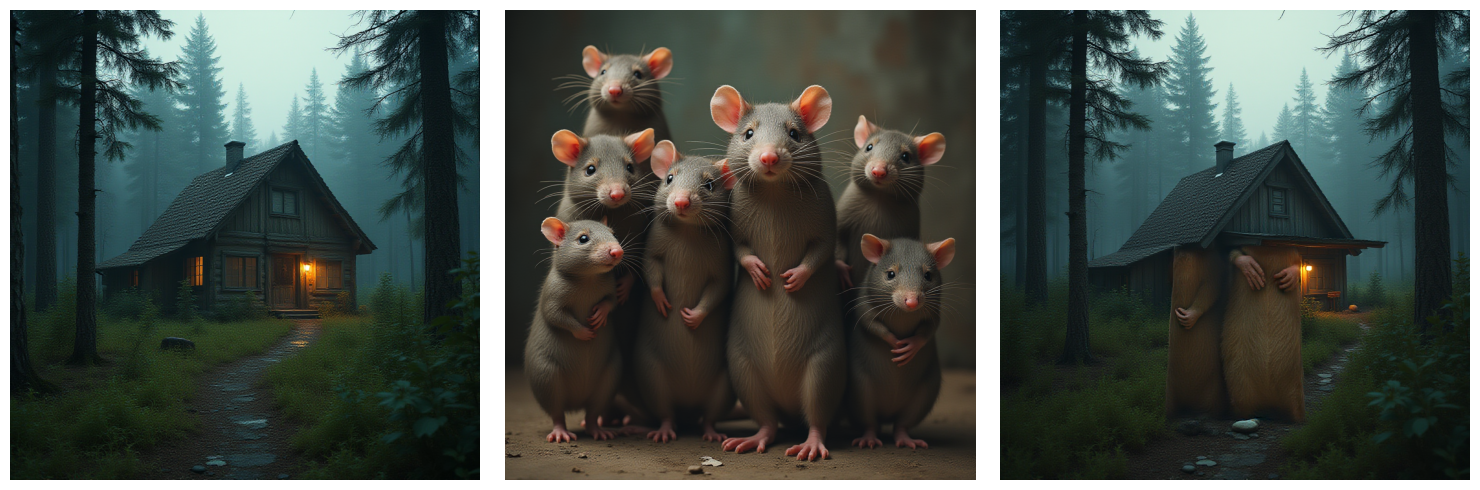

In [44]:
from functools import partial

images = cached_pipe.run_with_edit(
    ["a house in the forest", "group of rats", "a house in the forest"],
    num_inference_steps=10,
    seed=42,
    guidance_scale=3.5,
    empty_clip_embeddings=False,
    edit_fn=partial(patch_foreground_activations_flat, mask=mask.to(dtype=bool).transpose(0, 1)),
    layers_for_edit_fn=[i for i in range(18, 25)],
    stream="image"
).images

display_images(images)


In [ ]:
from diffusers import FlaxAutoencoderKL
from PIL import Image
import numpy as np

# 1. Load the VAE
vae = pipe.vae

# 2. Open and preprocess the image
img = Image.open("/dlabscratch1/anmari/dit-editor/benchmark_images_generations/Real-Real/0001 a professional photograph of a puppy in the snow, ultra realistic/bg01.jpg")# .convert("RGB")
img = img.resize((1024, 1024)) # , resample=Image.LANCZOS)
img

In [ ]:
 # [0, 1, 2, 17, 18, 25, 28, 53, 54, 56].  [28, 53, 54, 56, 25]
vital_layers = [f"transformer.transformer_blocks.{i}" for i in [0, 1, 17, 18]] + \
                [f"transformer.single_transformer_blocks.{i-19}" for i in [25, 28, 53, 54, 56]]

prompts = ["A pony in the forest", "A dog in the forest", "A cat in the forest", "A mouse in the forest"]
images = cached_pipe.run_inject_qkv(
    prompts,
    num_inference_steps=28,
    seed=42,
    guidance_scale=3.5,
    positions_to_inject=vital_layers,
    empty_clip_embeddings=False
).images

<class 'torch.Tensor'>


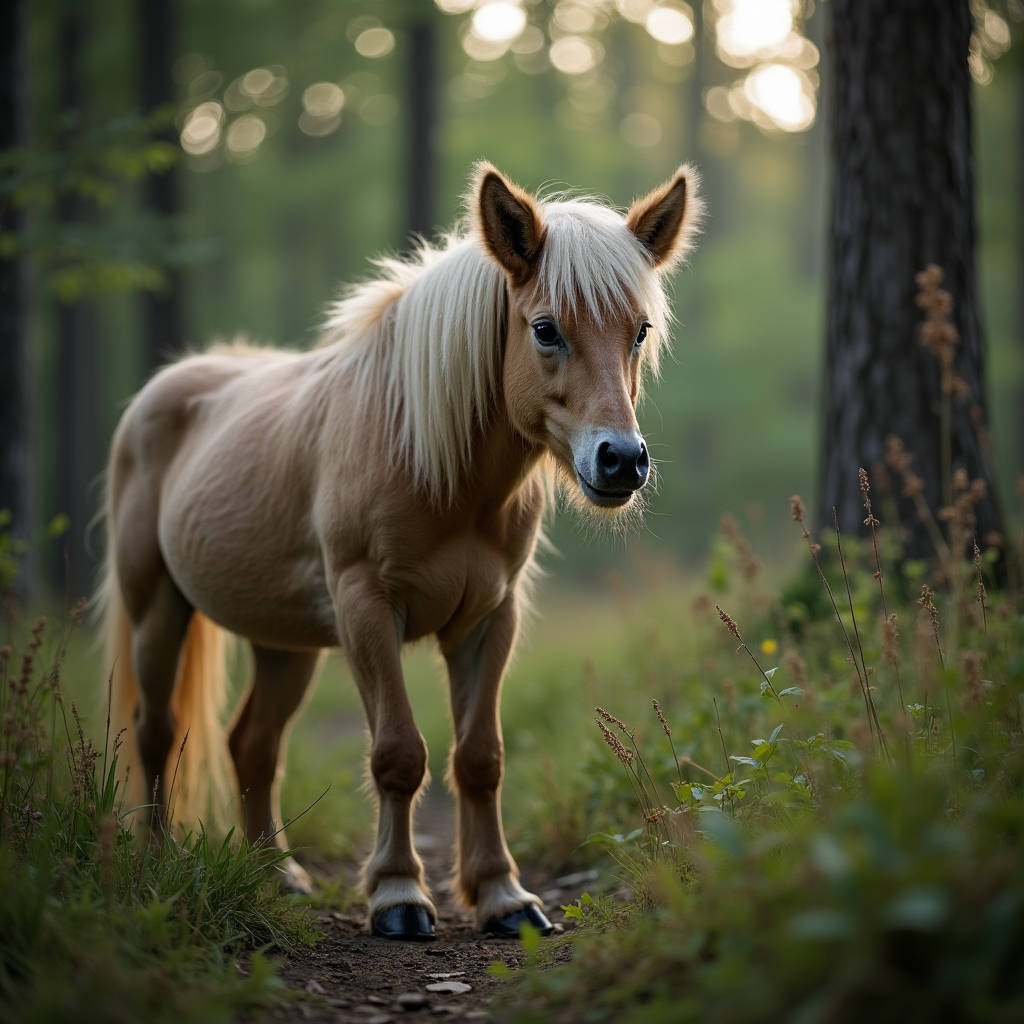

In [ ]:
dest_prompt = "A killer in the forest"
image = cached_pipe_dest.run_inject_qkv(
    dest_prompt,
    qkv_to_inject=cached_pipe.qkv_cache,
    positions_to_inject=vital_layers,
    num_inference_steps=28,
    guidance_scale=3.5,
    seed=42,
    empty_clip_embeddings=False
).images[0]
image.show()

In [5]:
del pipe
clear_all_gpu_memory()

Found 2 GPU(s).
GPU memory cleared across all available devices.
